In [3]:
# Import all the needful packages-----------------------
import numpy as np
import pandas as pd
import pandas_profiling
# ------------------------------------------------------

In [5]:
# Read the CSV file using 
carsales_df = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv", encoding='cp1252')

In [6]:
# Displaying Dataset

carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN
...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500.0,crossover,140,2.0,Gas,yes,2011,Tucson,front
9572,Volkswagen,2200.0,vagon,150,1.6,Petrol,yes,1986,Passat B2,front
9573,Mercedes-Benz,18500.0,crossover,180,3.5,Petrol,yes,2008,ML 350,full
9574,Lexus,16999.0,sedan,150,3.5,Gas,yes,2008,ES 350,front


In [11]:
type(carsales_df) # Exact type of collection

pandas.core.frame.DataFrame

In [7]:
carsales_df.shape

(9576, 10)

In [15]:
carsales_df.columns # Gives list of columns in the DataSet

Index(['car', 'price', 'body', 'mileage', 'engV', 'engType', 'registration',
       'year', 'model', 'drive'],
      dtype='object')

In [5]:
carsales_df.info() # Details about Dataframe index, Column Name, Non-null Count, and Datatype of the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


In [14]:
carsales_df.describe() # Describes the Data of the DataSet. Statistics of DatSet, Min, Max, Inter Quartile Ranges for all quantitative variables

,price,mileage,engV,year
count,9576.000000,9576.000000,9142.000000,9576.000000
mean,15633.317316,138.862364,2.646344,2006.605994
std,24106.523436,98.629754,5.927699,7.067924
min,0.000000,0.000000,0.100000,1953.000000
25%,4999.000000,70.000000,1.600000,2004.000000
50%,9200.000000,128.000000,2.000000,2008.000000
75%,16700.000000,194.000000,2.500000,2012.000000
max,547800.000000,999.000000,99.990000,2016.000000


From this Describe function gives us basic statistics computed on the dataset
* Among the 4 numerical columns, engine has less values in count (all are 9756 except engV). There could be some missing data which should be cleansed.
* *Price* & *Mileage* is having min value as '0', which looks incorrect or outlier. Could be potential candidate for correction/discard the data

In [17]:
carsales_df.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

* We can observe engV and drive is missing/null values. 
* These missing or null values we cant replace with any default value

In [20]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("Profile_Before_Processing.html")

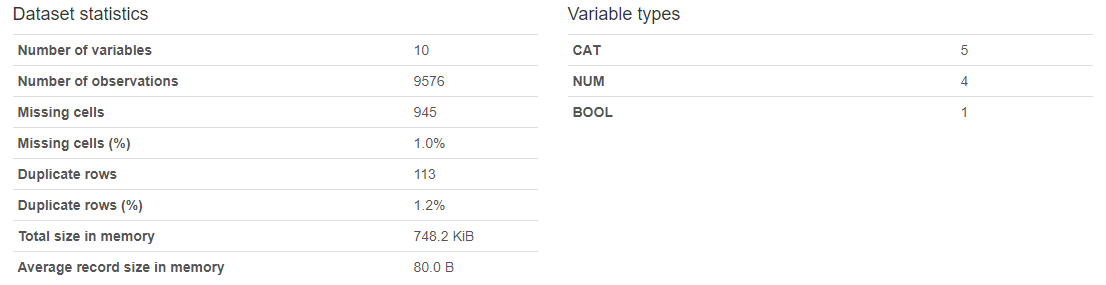

## Above profiing report describes
* There are 113 duplicated rows (Action - Remove the duplcates)
* 1% of missing cells are in the dataset (Action - Replace with default/mean value or discard the record)
* 5 Categorical variables, 4 numeric variables and 1 boolean value

In [6]:
# Identify the Duplicates

carsales_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9571    False
9572    False
9573    False
9574    False
9575    False
Length: 9576, dtype: bool

In [7]:
duplicated_df = carsales_df[carsales_df.duplicated()]
duplicated_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
18,Nissan,16600.0,crossover,83,2.0,Petrol,yes,2013,X-Trail,full
42,Mercedes-Benz,20400.0,sedan,190,1.8,Gas,yes,2011,E-Class,rear
70,Mercedes-Benz,0.0,crossover,0,3.0,Diesel,yes,2016,GLE-Class,full
86,Toyota,103999.0,crossover,0,4.5,Diesel,yes,2016,Land Cruiser 200,full
98,Mercedes-Benz,20400.0,sedan,190,1.8,Gas,yes,2011,E-Class,rear
...,...,...,...,...,...,...,...,...,...,...
9156,Volkswagen,15700.0,sedan,110,1.8,Petrol,yes,2011,Passat B7,front
9163,Mercedes-Benz,20500.0,sedan,222,5.5,Petrol,yes,2006,S 500,rear
9164,VAZ,3900.0,hatch,121,1.4,Petrol,yes,2008,1119,front
9169,Hyundai,12900.0,crossover,49,2.7,Petrol,yes,2008,Tucson,full


In [8]:
carsales_df.shape

(9576, 10)

In [7]:
# lets Drop the duplicate Value

carsales_df.drop_duplicates(inplace=True)
carsales_df.shape

(9463, 10)

In [10]:
carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68,2.5,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173,1.8,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135,5.5,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162,1.8,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91,NaN,Other,yes,2013,E-Class,NaN
...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500.0,crossover,140,2.0,Gas,yes,2011,Tucson,front
9572,Volkswagen,2200.0,vagon,150,1.6,Petrol,yes,1986,Passat B2,front
9573,Mercedes-Benz,18500.0,crossover,180,3.5,Petrol,yes,2008,ML 350,full
9574,Lexus,16999.0,sedan,150,3.5,Gas,yes,2008,ES 350,front


In [11]:
carsales_df['body'].unique()

array(['crossover', 'sedan', 'other', 'van', 'vagon', 'hatch'],
      dtype=object)

In [12]:
pd.DataFrame(carsales_df.groupby('body')['engV'].mean())

,engV
body,
crossover,3.173186
hatch,1.837908
other,2.945148
sedan,2.633747
vagon,2.252189
van,2.592071


In [13]:
pd.DataFrame(carsales_df.groupby('body')['engV'].mean()).describe()

,engV
count,6.000000
mean,2.572375
std,0.478759
min,1.837908
25%,2.337159
50%,2.612909
75%,2.867298
max,3.173186


In [72]:
carsales_df[(carsales_df['engV']< 0.5)]

,car,price,body,mileage,engV,engType,registration,year,model,drive
308,Nissan,17700.0,hatch,21,0.11,Other,yes,2014,Leaf,front
403,Nissan,15700.0,hatch,22,0.11,Other,yes,2013,Leaf,front
9247,Ford,24300.0,hatch,25,0.14,Other,yes,2013,Focus,front
9251,Tesla,54000.0,sedan,49,0.10,Other,yes,2013,Model S,rear


In [83]:
carsales_df[carsales_df['engV']> 60]

,car,price,body,mileage,engV,engType,registration,year,model,drive
184,Audi,4600.0000,vagon,242,99.99,Diesel,no,2004,A6,front
256,Subaru,14000.0000,crossover,171,99.99,Petrol,yes,2010,Forester,full
499,Smart,4200.0000,other,130,99.99,Petrol,yes,2002,Fortwo,NaN
1116,Renault,0.0000,van,192,99.99,Diesel,yes,2011,Kangoo ãðóç.,front
1158,Audi,4000.0000,sedan,260,99.99,Diesel,no,2000,A6,full
1647,Volkswagen,11350.0000,van,190,75.00,Diesel,yes,2011,T5 (Transporter) ãðóç,front
1672,ZAZ,1800.0000,hatch,150,99.99,Gas,yes,2004,1102 Òàâðèÿ,front
1752,Mazda,12850.0000,crossover,125,99.99,Other,yes,2009,CX-7,full
2217,BMW,6800.0000,crossover,242,99.99,Diesel,no,2005,X3,NaN
2321,VAZ,1250.0000,sedan,150,99.99,Gas,yes,1987,2105,rear


<AxesSubplot:ylabel='Frequency'>

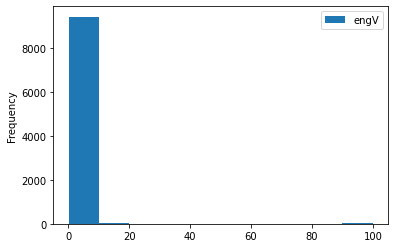

In [80]:
pd.DataFrame(carsales_df['engV']).plot.hist()

In [27]:
engV_null_df = carsales_df[(carsales_df['engV'].isnull() == True)]
engV_null_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
4,Mercedes-Benz,33000.000,vagon,91,NaN,Other,yes,2013,E-Class,NaN
13,BMW,4700.000,sedan,200,NaN,Petrol,yes,1996,316,rear
30,Nissan,13980.000,hatch,31,NaN,Other,yes,2013,Leaf,front
31,Nissan,17300.000,hatch,24,NaN,Other,yes,2013,Leaf,front
37,Audi,2850.000,sedan,260,NaN,Other,no,1999,A6,NaN
...,...,...,...,...,...,...,...,...,...,...
9470,Chrysler,0.000,vagon,198,NaN,Petrol,yes,2001,PT Cruiser,front
9480,Renault,8100.000,van,135,NaN,Diesel,yes,2008,Kangoo ïàññ.,front
9515,Renault,5000.000,vagon,150,NaN,Other,yes,2006,Kangoo ïàññ.,front
9546,VAZ,907.725,sedan,1,NaN,Other,yes,1986,2106,rear


In [15]:
engV_avg = pd.DataFrame(carsales_df.groupby(['body','drive'])['engV'].mean())
engV_avg

engV
body      drive          
crossover front  1.830075
          full   3.244113
          rear   2.314286
hatch     front  1.754253
          full   2.395455
          rear   1.654545
other     front  1.897892
          full   3.227500
          rear   3.157397
sedan     front  2.177555
          full   4.158622
          rear   3.239831
vagon     front  2.209124
          full   2.632673
          rear   2.237500
van       front  2.541667
          full   2.685106
          rear   2.365347

In [39]:
engV_make_model_avg = pd.DataFrame(carsales_df.groupby(['car','model'])['engV'].mean())
engV_make_model_avg

engV
car   model           
Acura MDX         3.62
      RL          3.50
      TL          3.20
      TLX         2.40
      ZDX         3.70
...                ...
ZX    LandMark    2.40
ËUAZ  1301        1.70
      1302        1.20
      969 Âîëûíü  1.50
      969Ì        1.20

[908 rows x 1 columns]

In [19]:
# Defind a function to return Avg engV value based on body and drive

def get_engine_avg_val(body, drive, df):
    if pd.isnull(drive):
        drive = 'front'
    return df.xs(body, level='body')['engV'].loc[drive]

In [20]:
# Checking value retrieved correct or not
get_engine_avg_val('crossover', 'front', engV_avg)

1.830075187969924

In [21]:
get_engine_avg_val('crossover', None, engV_avg)

1.830075187969924

In [40]:
def get_engineV_avg_val(make, model, df):
    return df.xs(make, level='car')['engV'].loc[model]


In [42]:
get_engineV_avg_val('Acura', 'RL', engV_make_model_avg)

3.5

In [43]:
def set_engV_missing_values():
    for index in engV_null_df.index:
        if pd.isnull(carsales_df.loc[index,'engV']) == True:
            carsales_df.loc[index,'engV'] = get_engine_avg_val(engV_null_df.loc[index,'body'], engV_null_df.loc[index, 'drive'], engV_avg)
            

In [46]:
def set_engV_missing_values(byMakeModel=False):
    for index in engV_null_df.index:
        if pd.isnull(carsales_df.loc[index,'engV']) == True:
            if byMakeModel == True:
                carsales_df.loc[index,'engV'] = get_engineV_avg_val(engV_null_df.loc[index,'car'], engV_null_df.loc[index, 'model'], engV_make_model_avg)
            else:
                carsales_df.loc[index,'engV'] = get_engine_avg_val(engV_null_df.loc[index,'body'], engV_null_df.loc[index, 'drive'], engV_avg)
            

In [54]:
# For missing values of engV, primarily we are taking value from Car make and model
# still if any values are missing, will be updated based on body and drive

set_engV_missing_values(True) 
set_engV_missing_values()

In [55]:
carsales_df[(carsales_df['engV'].isnull() == True)]

,car,price,body,mileage,engV,engType,registration,year,model,drive


In [10]:
'''
Function that removes the null entries of drive and returns dataframe
'''
def get_clensed_data_for_drive():
    return pd.DataFrame(carsales_df[carsales_df.drive.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_drive(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        drive_df = get_clensed_data_for_drive()
        drive_make = drive_df[drive_df.car == car_make].drive
        if drive_make.count() > 0:
            return drive_make.mode()
        else:
            return drive_df.drive.mode()
        
        


In [12]:
'''
Create a staging "drive mode" dataframe for  all combinations of make and model
'''
drive_mode = carsales_df.groupby(['car','model']).drive.apply(compute_drive).reset_index()
drive_mode.rename(columns={'drive':'drive_mode'}, inplace=True)


In [13]:
drive_mode

,car,model,level_2,drive_mode
0,Acura,MDX,0,full
1,Acura,RL,0,full
2,Acura,TL,0,front
3,Acura,TLX,0,front
4,Acura,ZDX,0,full
...,...,...,...,...
914,ZX,LandMark,0,full
915,ËUAZ,1301,0,full
916,ËUAZ,1302,0,full
917,ËUAZ,969 Âîëûíü,0,full


In [15]:
'''
Function that return drive value for missing records
'''
def get_missing_drive(r):
    if pd.isnull(r.drive):
        return drive_mode[(drive_mode.car == r.car) & (drive_mode.model == r.model)].drive_mode
    else:
        return r.drive
    
'''
Fix the missing drive values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

carsales_df.drive = carsales_df.apply(get_missing_drive, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

--------------Before fix-----------------
(510, 10)
--------------After fix -----------------
(0, 10)
